In [300]:
#预测二手车价格打卡
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [301]:
dfCar = pd.read_csv("data//used_car_train_20200313.csv")
dfCar.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914763
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482


In [302]:
dfCar.shape

(150000, 31)

In [303]:
dfCarTest = pd.read_csv("data//used_car_testA_20200313.csv")
#dfCarTest.head()

In [304]:
dfCarTest.shape#A测试集没有price，用来做最后预测结果，训练可忽略

(50000, 30)

In [305]:
dfCar.isnull().sum() #查看空值

SaleID                   0
name                     0
regDate                  0
model                    1
brand                    0
bodyType              4506
fuelType              8680
gearbox               5981
power                    0
kilometer                0
notRepairedDamage    24324
regionCode               0
seller                   0
offerType                0
creatDate                0
price                    0
v_0                      0
v_1                      0
v_2                      0
v_3                      0
v_4                      0
v_5                      0
v_6                      0
v_7                      0
v_8                      0
v_9                      0
v_10                     0
v_11                     0
v_12                     0
v_13                     0
v_14                     0
dtype: int64

In [306]:
#=1）数据分析：=
#查看数据信息
dfCar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 31 columns):
SaleID               150000 non-null int64
name                 150000 non-null int64
regDate              150000 non-null int64
model                149999 non-null float64
brand                150000 non-null int64
bodyType             145494 non-null float64
fuelType             141320 non-null float64
gearbox              144019 non-null float64
power                150000 non-null int64
kilometer            150000 non-null float64
notRepairedDamage    125676 non-null float64
regionCode           150000 non-null int64
seller               150000 non-null int64
offerType            150000 non-null int64
creatDate            150000 non-null int64
price                150000 non-null int64
v_0                  150000 non-null float64
v_1                  150000 non-null float64
v_2                  150000 non-null float64
v_3                  150000 non-null float64
v_4      

In [307]:
#缺失数据统计：
#model 149999 少1
#bodyType 145494 少4506
#fuelType 141320 少8680
#gearbox  144019 少5981


In [308]:
#删掉model为空的数据行（缺失少的删掉）
dfCar = dfCar.dropna(subset=['model'],axis=0)


In [309]:
dfCar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149999 entries, 0 to 149999
Data columns (total 31 columns):
SaleID               149999 non-null int64
name                 149999 non-null int64
regDate              149999 non-null int64
model                149999 non-null float64
brand                149999 non-null int64
bodyType             145493 non-null float64
fuelType             141319 non-null float64
gearbox              144018 non-null float64
power                149999 non-null int64
kilometer            149999 non-null float64
notRepairedDamage    125675 non-null float64
regionCode           149999 non-null int64
seller               149999 non-null int64
offerType            149999 non-null int64
creatDate            149999 non-null int64
price                149999 non-null int64
v_0                  149999 non-null float64
v_1                  149999 non-null float64
v_2                  149999 non-null float64
v_3                  149999 non-null float64
v_4      

In [310]:
#==分类数据的填充方法探索==
dfCar["bodyType"].unique()#bodyType有9种

array([ 1.,  2.,  0.,  5.,  3., nan,  6.,  7.,  4.])

In [311]:
#分组统计一下各种类型有多少
bodyTypeC = dfCar.groupby(['bodyType'])['SaleID'].count()
bodyTypeC

bodyType
0.0    41420
1.0    35272
2.0    30324
3.0    13491
4.0     9609
5.0     7607
6.0     6481
7.0     1289
Name: SaleID, dtype: int64

In [312]:
#统计下占比
bodyTypeCRate = dfCar.groupby(['bodyType'])['SaleID'].count()/150000
bodyTypeCRate

bodyType
0.0    0.276133
1.0    0.235147
2.0    0.202160
3.0    0.089940
4.0    0.064060
5.0    0.050713
6.0    0.043207
7.0    0.008593
Name: SaleID, dtype: float64

In [313]:
#【或不用分组，直接通过以下方法直接查看唯一值】
dfCar['bodyType'].value_counts() 

0.0    41420
1.0    35272
2.0    30324
3.0    13491
4.0     9609
5.0     7607
6.0     6481
7.0     1289
Name: bodyType, dtype: int64

In [314]:
#缺少的4506条bodyType，按各类占比同比例补充假类别
bodyTypeFake = round(4506*dfCar.groupby(['bodyType'])['SaleID'].count()/150000)
bodyTypeFake

bodyType
0.0    1244.0
1.0    1060.0
2.0     911.0
3.0     405.0
4.0     289.0
5.0     229.0
6.0     195.0
7.0      39.0
Name: SaleID, dtype: float64

In [315]:
dfCar[dfCar['bodyType'].isnull()].shape

(4506, 31)

In [316]:
dfCar[dfCar['bodyType'].isnull()].sample(n=1244).shape

(1244, 31)

In [317]:
#按比例填充？待查
#dfCar[dfCar['bodyType'].isnull()].sample(n=1244)['bodyType'].fillna(0.0,inplace=True)

In [318]:
#dfCar.info()#上面填充方法没有生效

In [319]:
#dfCar[dfCar['bodyType'].isnull()].sample(n=1244)['bodyType']=0.0
#dfCar[dfCar['bodyType'].isnull()].sample(n=1060)['bodyType']=1.0
#dfCar[dfCar['bodyType'].isnull()].sample(n=911)['bodyType']=2.0
#dfCar[dfCar['bodyType'].isnull()].sample(n=405)['bodyType']=3.0
#dfCar[dfCar['bodyType'].isnull()].sample(n=289)['bodyType']=4.0
#dfCar[dfCar['bodyType'].isnull()].sample(n=229)['bodyType']=5.0
#dfCar[dfCar['bodyType'].isnull()].sample(n=195)['bodyType']=6.0

In [320]:
#或采取原则：对于分类数据的填充，一般使用分类值中出现次数最多的值来填充（可能是已经很多了再多点也不会有大影响）。
#但我们这个4000多条太多了，最多的40000多加上4000多影响很大
#采用原则：【用前后数据填充】吧【感觉这种用前后填充的方法，最好先把数据shuffle打算下】
dfCar['bodyType'] = dfCar['bodyType'].fillna(method='pad')#用前一个不为空的数据填充，bfill是后一个
#注意赋值回去。
dfCar.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 149999 entries, 0 to 149999
Data columns (total 31 columns):
SaleID               149999 non-null int64
name                 149999 non-null int64
regDate              149999 non-null int64
model                149999 non-null float64
brand                149999 non-null int64
bodyType             149999 non-null float64
fuelType             141319 non-null float64
gearbox              144018 non-null float64
power                149999 non-null int64
kilometer            149999 non-null float64
notRepairedDamage    125675 non-null float64
regionCode           149999 non-null int64
seller               149999 non-null int64
offerType            149999 non-null int64
creatDate            149999 non-null int64
price                149999 non-null int64
v_0                  149999 non-null float64
v_1                  149999 non-null float64
v_2                  149999 non-null float64
v_3                  149999 non-null float64
v_4      

In [321]:
#填充完以后再看下各类比例变化大吗？还可以，影响不大。
bodyTypeCRate = dfCar.groupby(['bodyType'])['SaleID'].count()/150000
bodyTypeCRate
#之前是
#0.0    0.276133
#1.0    0.235147
#2.0    0.202160
#3.0    0.089940
#4.0    0.064060
#5.0    0.050713
#6.0    0.043207
#7.0    0.008593

bodyType
0.0    0.284967
1.0    0.242240
2.0    0.208513
3.0    0.092687
4.0    0.066000
5.0    0.052220
6.0    0.044533
7.0    0.008833
Name: SaleID, dtype: float64

In [322]:
#用同上方法处理fuelType 少8680
dfCar['fuelType'].unique()

array([ 0.,  1., nan,  2.,  3.,  4.,  5.,  6.])

In [323]:
fuelTypeRate_1 = dfCar.groupby(['fuelType'])['SaleID'].count()/149999
print(fuelTypeRate_1)

fuelType
0.0    0.611044
1.0    0.313269
2.0    0.014747
3.0    0.001747
4.0    0.000787
5.0    0.000300
6.0    0.000240
Name: SaleID, dtype: float64


In [324]:
fuelTypeRate_c = dfCar.groupby(['fuelType'])['SaleID'].count()
fuelTypeRate_c

fuelType
0.0    91656
1.0    46990
2.0     2212
3.0      262
4.0      118
5.0       45
6.0       36
Name: SaleID, dtype: int64

In [325]:
dfCar['fuelType'] = dfCar['fuelType'].fillna(method='pad')#注意前面千万不要少了['fuelType']
dfCar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149999 entries, 0 to 149999
Data columns (total 31 columns):
SaleID               149999 non-null int64
name                 149999 non-null int64
regDate              149999 non-null int64
model                149999 non-null float64
brand                149999 non-null int64
bodyType             149999 non-null float64
fuelType             149999 non-null float64
gearbox              144018 non-null float64
power                149999 non-null int64
kilometer            149999 non-null float64
notRepairedDamage    125675 non-null float64
regionCode           149999 non-null int64
seller               149999 non-null int64
offerType            149999 non-null int64
creatDate            149999 non-null int64
price                149999 non-null int64
v_0                  149999 non-null float64
v_1                  149999 non-null float64
v_2                  149999 non-null float64
v_3                  149999 non-null float64
v_4      

In [326]:
fuelTypeRate_2 = dfCar.groupby(['fuelType'])['SaleID'].count()/149999
print(fuelTypeRate_2)
#【对比比例：起初发现变化很大，是前一个bodyType的值，
#检查发现dfCar['fuelType'] = dfCar['bodyType'].fillna(method='pad'
#上面填充时写错，用bodyType填充的。
#改后数据对比下，比例填充前后变化不大，可以的。】

#0.0    0.611044
#1.0    0.313269
#2.0    0.014747
#3.0    0.001747
#4.0    0.000787
#5.0    0.000300
#6.0    0.000240
#

fuelType
0.0    0.648598
1.0    0.332376
2.0    0.015747
3.0    0.001887
4.0    0.000833
5.0    0.000313
6.0    0.000247
Name: SaleID, dtype: float64


In [327]:
#填充#gearbox  144019 少5981
dfCar['gearbox'].unique()#只有两种，变速箱，手动档，自动档

array([ 0.,  1., nan])

In [328]:
gearboxRate_1 = dfCar.groupby(['gearbox'])['SaleID'].count()/149999
gearboxRate_1

gearbox
0.0    0.744158
1.0    0.215968
Name: SaleID, dtype: float64

In [329]:
gearboxRate_c = dfCar.groupby(['gearbox'])['SaleID'].count()
gearboxRate_c

gearbox
0.0    111623
1.0     32395
Name: SaleID, dtype: int64

In [330]:
dfCar['gearbox'] = dfCar['gearbox'].fillna(method = 'pad')
dfCar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149999 entries, 0 to 149999
Data columns (total 31 columns):
SaleID               149999 non-null int64
name                 149999 non-null int64
regDate              149999 non-null int64
model                149999 non-null float64
brand                149999 non-null int64
bodyType             149999 non-null float64
fuelType             149999 non-null float64
gearbox              149999 non-null float64
power                149999 non-null int64
kilometer            149999 non-null float64
notRepairedDamage    125675 non-null float64
regionCode           149999 non-null int64
seller               149999 non-null int64
offerType            149999 non-null int64
creatDate            149999 non-null int64
price                149999 non-null int64
v_0                  149999 non-null float64
v_1                  149999 non-null float64
v_2                  149999 non-null float64
v_3                  149999 non-null float64
v_4      

In [331]:
gearboxRate_2 = dfCar.groupby(['gearbox'])['SaleID'].count()/149999
gearboxRate_2
#gearbox 前后比例变化不大，可以的。
#0.0    0.744158
#1.0    0.215968

gearbox
0.0    0.774818
1.0    0.225182
Name: SaleID, dtype: float64

In [332]:
#【查看数据发现notRepairedDamage列有一些值为“-”的记录，是否有损坏，这一列应该只有两个值，"-"值需要像空值一样替换】
#dfCar["notRepairedDamage"].value_counts() # 统计唯一值，看到-
#【这里处是的时候采取的是，一开始csv文件把-处理成和其它一样的空数据，统一处理。】
#统计下
damage_1 = dfCar.groupby(['notRepairedDamage'])['SaleID'].count()
damage_1#2万多条

notRepairedDamage
0.0    111360
1.0     14315
Name: SaleID, dtype: int64

In [333]:
damageRate_1 = dfCar.groupby(['notRepairedDamage'])['SaleID'].count()/149999
print(damageRate_1)#2万多条
#0.742405
#0.095434
print(0.742405/0.095434)

notRepairedDamage
0.0    0.742405
1.0    0.095434
Name: SaleID, dtype: float64
7.779250581553743


In [334]:
#补notRepairedDamage，2万多条
dfCar['notRepairedDamage'] = dfCar['notRepairedDamage'].fillna(method='pad')
dfCar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149999 entries, 0 to 149999
Data columns (total 31 columns):
SaleID               149999 non-null int64
name                 149999 non-null int64
regDate              149999 non-null int64
model                149999 non-null float64
brand                149999 non-null int64
bodyType             149999 non-null float64
fuelType             149999 non-null float64
gearbox              149999 non-null float64
power                149999 non-null int64
kilometer            149999 non-null float64
notRepairedDamage    149999 non-null float64
regionCode           149999 non-null int64
seller               149999 non-null int64
offerType            149999 non-null int64
creatDate            149999 non-null int64
price                149999 non-null int64
v_0                  149999 non-null float64
v_1                  149999 non-null float64
v_2                  149999 non-null float64
v_3                  149999 non-null float64
v_4      

In [335]:
damageRate_2 = dfCar.groupby(['notRepairedDamage'])['SaleID'].count()/149999
damageRate_2#2万多条
#之前比例
#0.742405
#0.095434
print(0.742405/0.095434)
#7.7
print(0.885806/0.114194)
#7.75702751458045
#差不多

7.779250581553743
7.75702751458045


In [336]:
#常试下直接替换-，替换后空值处理
#dfCar['notRepairedDamage'].replace('-', np.nan, inplace = True)
#dfCar.info()

In [337]:
#damageRate_2 = dfCar.groupby(['notRepairedDamage'])['SaleID'].count()/149999
#damageRate_2#2万多条

In [338]:
#整体打印下各列样本各类分布情况（发现异常分布的倾斜值）
for col in dfCar.columns:
    print(col)
    print(dfCar[col].value_counts())
    print()
    
#seller
#0    149998
#1         1
#Name: seller, dtype: int64
#
#offerType
#0    149999
#Name: offerType, dtype: int64
#以上两列数据正负例分布太大，对价格预测没有判断标准，不能做依据，删除


SaleID
2047      1
107806    1
9518      1
15661     1
13612     1
         ..
8913      1
10960     1
53967     1
56014     1
0         1
Name: SaleID, Length: 149999, dtype: int64

name
708       282
387       282
55        280
1541      263
203       233
         ... 
7123        1
11221       1
13270       1
15319       1
184730      1
Name: name, Length: 99661, dtype: int64

regDate
20000008    180
20000011    158
20000004    157
20000010    157
20000002    155
           ... 
19910807      1
19910902      1
20151209      1
19911011      1
20151201      1
Name: regDate, Length: 3894, dtype: int64

model
0.0      11762
19.0      9573
4.0       8445
1.0       6038
29.0      5186
         ...  
245.0        2
209.0        2
240.0        2
242.0        2
247.0        1
Name: model, Length: 248, dtype: int64

brand
0     31480
4     16737
14    16089
10    14249
1     13794
6     10217
9      7306
5      4665
13     3817
11     2945
3      2461
7      2361
16     2223
8      2077
25   

In [339]:
del dfCar['seller']
del dfCar['offerType']


In [340]:
dfCar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149999 entries, 0 to 149999
Data columns (total 29 columns):
SaleID               149999 non-null int64
name                 149999 non-null int64
regDate              149999 non-null int64
model                149999 non-null float64
brand                149999 non-null int64
bodyType             149999 non-null float64
fuelType             149999 non-null float64
gearbox              149999 non-null float64
power                149999 non-null int64
kilometer            149999 non-null float64
notRepairedDamage    149999 non-null float64
regionCode           149999 non-null int64
creatDate            149999 non-null int64
price                149999 non-null int64
v_0                  149999 non-null float64
v_1                  149999 non-null float64
v_2                  149999 non-null float64
v_3                  149999 non-null float64
v_4                  149999 non-null float64
v_5                  149999 non-null float64
v_6  

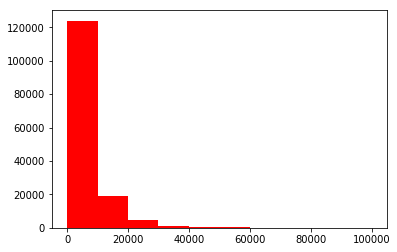

In [341]:
#==数值型数据归一化==
#查看预测值分布
#画直方图
plt.hist(dfCar['price'], orientation = 'vertical',histtype = 'bar', color ='red')
plt.show()

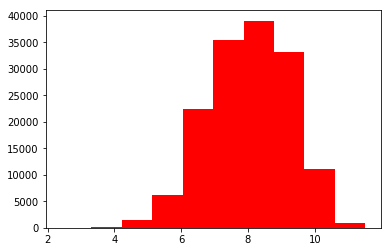

In [342]:
#可见不是正态分布，集在中20000以内。
#归一化，取对数，变到0-1之间的正态分布
#log变换
plt.hist(np.log(dfCar['price']), orientation = 'vertical',histtype = 'bar', color ='red') 
plt.show()

In [343]:
#将价格取对数，归一化处理，【为什么取对数不影响预测结果？因为都是统一处理，一样处理的，相对没变，归一化后使模型能尽快收敛】
dfCar['price'] = np.log(dfCar['price'])

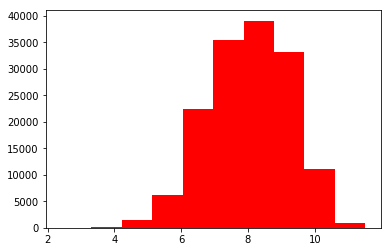

In [349]:
plt.hist(dfCar['price'], orientation = 'vertical',histtype = 'bar', color ='red')
plt.show()

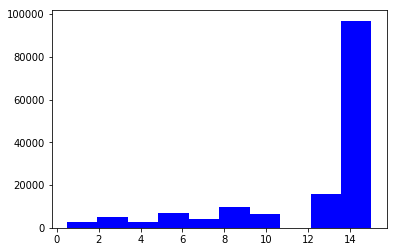

In [350]:
#同样处理气车行驶公里处kilometer
plt.hist(dfCar['kilometer'], orientation = 'vertical',histtype = 'bar', color ='blue')
plt.show()

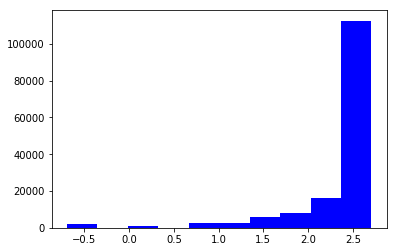

In [351]:
plt.hist(np.log(dfCar['kilometer']), orientation = 'vertical',histtype = 'bar', color ='blue')
plt.show()#【为什么这个取对数变化不大？因为上面那个差距距大，所以变到0-1之间会出现规律，这个本身差距不大。可不做处理】

In [ ]:
#其它都是类别数据，没有数值数据了

In [347]:
#没有缺失值了，把数据保存
dfCar.to_csv("data//ready_car_train.csv")